# `20180516a` - JSON Client - version e from un0rick

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve
import json 
import re
import glob, os

## Creating the set of acquisitions

data/20180516a-3.json
second


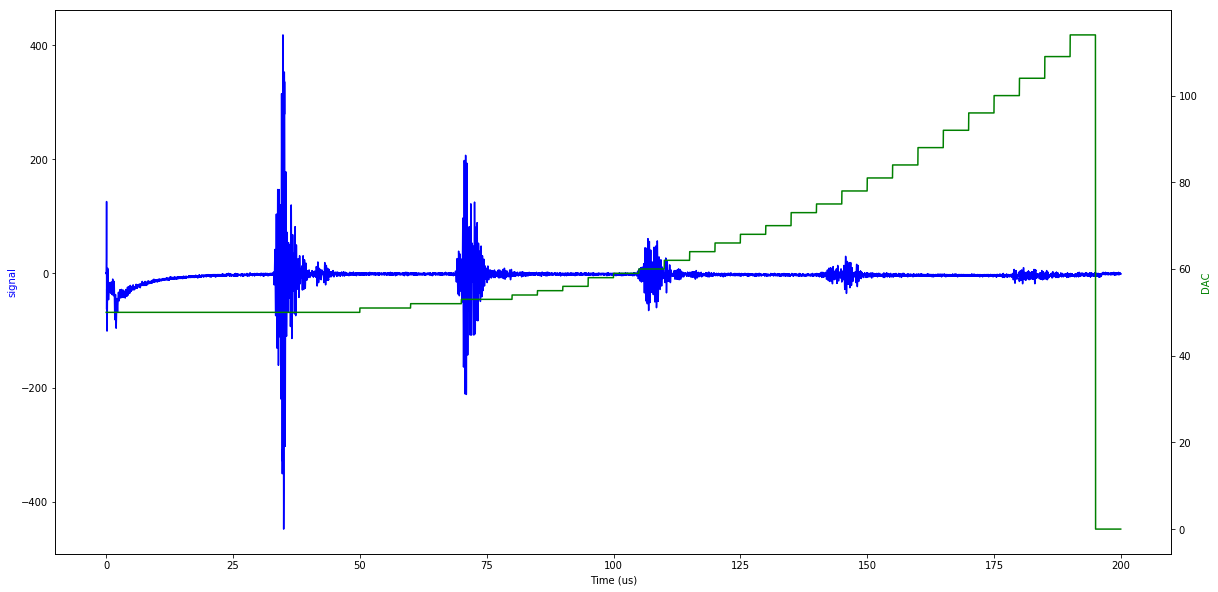

data/20180516a-1.json
second


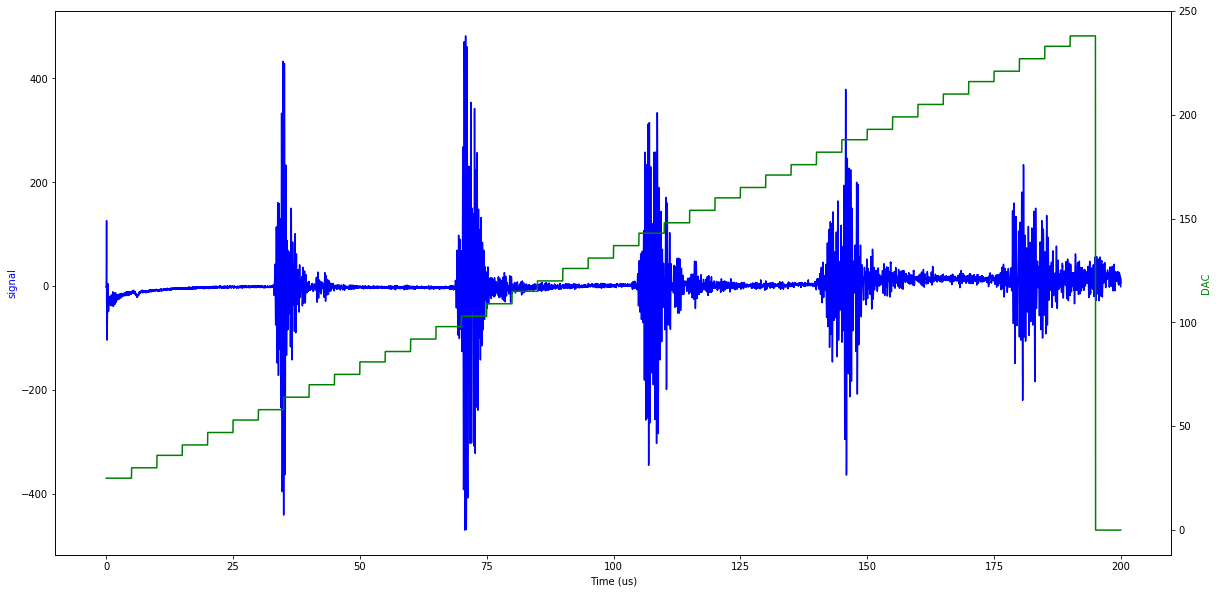

data/20180516a-2.json
first


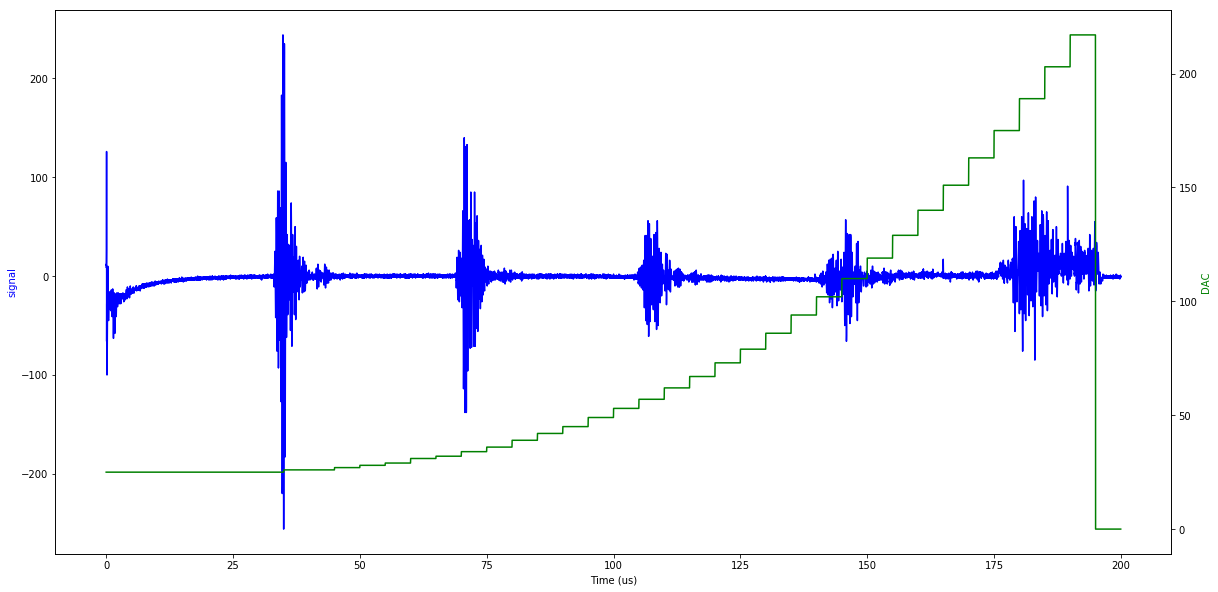

data/20180516a-4.json
first


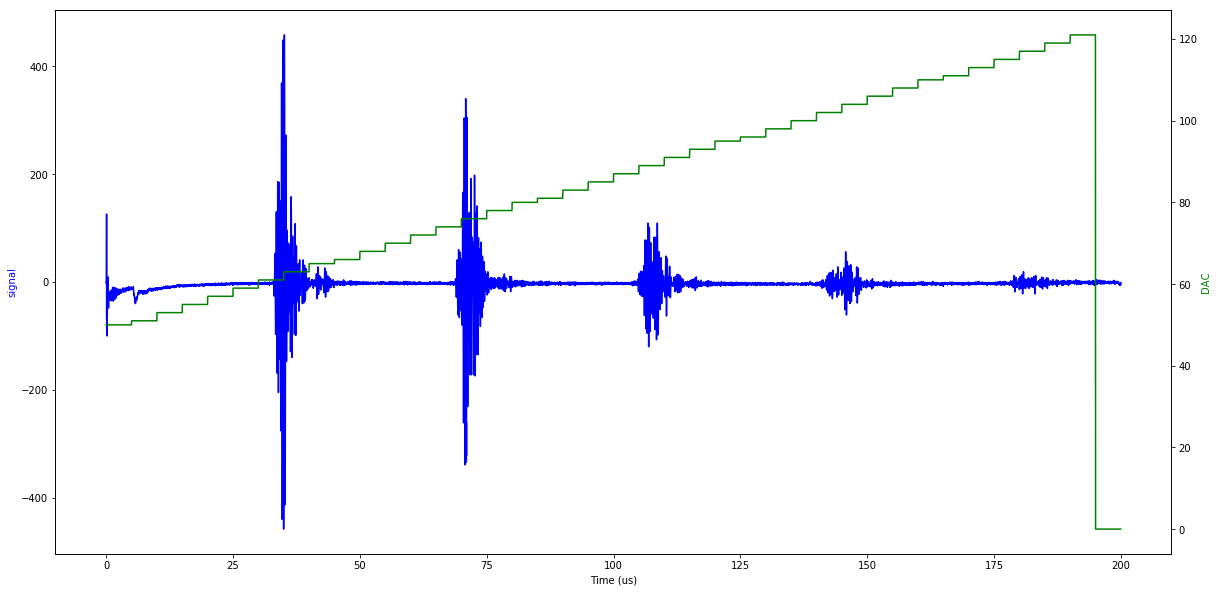

In [37]:
DataSet = {}

for data in glob.glob("data/*.json"):
    print data
    
    
    with open(data) as json_data:
        IDLine = []
        TT1 = []
        TT2 = []
        tmp = [] 
        DataSet[data] = {}
        d = json.load(json_data)
        json_data.close()
        
        A = d["data"][1:]
        
        if (A[0]) > 128:
            print "first"
            for i in range(len(A)/2-1):
                value = 128*(A[2*i+0]&0b0000111) + A[2*i+1] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16) # Identify the # of the line
                #TT1.append( (A[2*i+0] & 0b00001000) / 0b1000)
                #TT2.append( (A[2*i+0] & 0b00010000) / 0b10000)
                tmp.append( value ) 
        else:
            print "second"
            for i in range(len(A)/2-1):
                value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16)
                #TT1.append( (A[2*i+1] & 0b00001000) / 0b1000)
                #TT2.append( (A[2*i+1] & 0b00010000) / 0b10000)
                tmp.append( value )
        DataSet[data]["data"] = tmp
        DataSet[data]["IDLine"] = IDLine
        #DataSet[data]["TT1"] = TT1
        #DataSet[data]["TT2"] = TT2
        DataSet[data]["registers"] = d["registers"]
        #DataSet[data]["position"] = d["position"]
        DataSet[data]["f"] = float(64/((1.0+int( d["registers"]["237"] ) )))
        t = [ 1.0*x/DataSet[data]["f"] for x in range(len(tmp))]
        DataSet[data]["t"] = t
        
        # Precising the DAC
        REG = [int(x) for x in d["registers"].keys() if int(x) < 100]
        REG.sort() 
        dac = []
        for k in REG:
            dac.append(d["registers"][str(k)])
        # Building the DAC timeline
        tdac = []
        for pts in t:
            i = int(pts/5.0)
            tdac.append(d["registers"][str(i+16)])
        
        # Updating the JSON
        d["DAC"] = tdac
        d["signal"] = tmp
        d["t"] = t
        d["IDLine"] = IDLine
        
        d1,d2 = data.split(".")
        with open(d1+"_full.us", 'w') as outfile:
            json.dump(d, outfile)
            
        #plt.figure()

        
        fig, ax1 = plt.subplots(figsize=(20,10))

        ax2 = ax1.twinx()
        
        ax2.plot(t, tdac, 'g-')
        ax1.plot(t, tmp, 'b-')

        ax1.set_xlabel('Time (us)')
        ax1.set_ylabel('signal', color='b')
        ax2.set_ylabel('DAC', color='g')
 
        plt.savefig(data+".jpg")
        plt.show() 

# Processing the data


In [28]:
with open("data/20180516a-1.json") as json_data:
        d = json.load(json_data)
        REG = [int(x) for x in d["registers"].keys() if int(x) < 100]
        REG.sort()
        print REG,len(REG)
        dac = []
        for k in REG:
            dac.append(d["registers"][str(k)])
        print dac

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56] 41
[25, 30, 36, 41, 47, 53, 58, 64, 70, 75, 81, 86, 92, 98, 103, 109, 115, 120, 126, 131, 137, 143, 148, 154, 160, 165, 171, 176, 182, 188, 193, 199, 205, 210, 216, 221, 227, 233, 238, 0, 0]
